<a href="https://colab.research.google.com/github/chavgova/Brain/blob/main/EEG_07_Bands_model_1channel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import codecs
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
import math
import numpy as np
from keras.models import model_from_json
from keras.utils.vis_utils import plot_model
from scipy import signal
import scipy.io as scio
import pandas as pd
from scipy.signal import hilbert
from tensorflow.keras.layers import Flatten
from sklearn.utils import shuffle

In [ ]:
dataset_folder_path = '/content/drive/MyDrive/Brain/EEG_data/Bands/'
model_path = '/content/drive/MyDrive/Brain/EEG_Models/'
model_name = 'EEG_07_Bands_model_1channel_f4'
channels_list = ['c3', 'c4', 'f3', 'f4', 'p3', 'p4']  # file names format 'c3_input_alpha.txt'
values_per_file = 40000
values_per_split = 10000
fs = 256 # Hz
# object_num = 4
channel_num = len(channels_list)

# Creating the DATASET

In [ ]:
dataset_files_list = [] 
dataset_files_list = os.listdir(dataset_folder_path)

print(dataset_files_list)
object_num = len(dataset_files_list)

['eeg_bands_object_1_fear', 'eeg_bands_object_2_joy', 'eeg_bands_object_1_joy', 'eeg_bands_object_2_fear']


In [ ]:
label_list = []

for item in dataset_files_list:
  if 'joy' in item:
    label_list.append('joy')
  elif 'fear' in item:
    label_list.append('fear')
print(label_list)    

['fear', 'joy', 'joy', 'fear']


# fs=256 Hz
Theta - 4 - 7.5 Hz

Alpha - 8 - 13.5 Hz

Beta -  14 - 30 Hz

Gamma - 30.5 - 40 Hz

In [ ]:
def formatDataFromTXT(contents):
  contents_list = contents.splitlines()
  contents_array = np.array([])

  contents_array = np.array([float(a) for a in contents_list])
  contents_array = contents_array[0:values_per_file]  ##############
  
  return contents_array 

def ReadObjectData(object_folder_name):
  object_data_3d = np.empty((channel_num, 4, values_per_file), float)  # object = (channels, bands, values) = (6, 4, values)
  i = 0 # channel counter
  for channel_name in channels_list:
    channel_data_2d = ReadChannelData(channel_name)
    object_data_3d[i] = channel_data_2d
    i+=1

  return object_data_3d

def ReadChannelData(channel_name):
  channel_data_2d = np.empty((4, values_per_file), float) # channel = (bands, values)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_alpha.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  alpha_data = formatDataFromTXT(contents)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_beta.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  beta_data = formatDataFromTXT(contents)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_gamma.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  gamma_data = formatDataFromTXT(contents)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_theta.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  theta_data = formatDataFromTXT(contents)
  channel_data_2d[0] = theta_data
  channel_data_2d[1] = alpha_data
  channel_data_2d[2] = beta_data
  channel_data_2d[3] = gamma_data

  return channel_data_2d

(objects, channels, bands, values) = (4, 6, 4, 40000)

In [ ]:
objects_data_4d = np.empty((object_num, channel_num, 4, values_per_file), float) # (objects, channels, bands, values) = (4, 6, 4, 40000)

j = 0 # object counter 

for object_folder_name in dataset_files_list:
  object_data_3d = ReadObjectData(object_folder_name)
  objects_data_4d[j] = object_data_3d
  j+=1

print(objects_data_4d)

[[[[ 2.3424050e-01  8.4389382e-01  1.4500050e+00 ... -1.3676524e-01
    -1.2533819e-01 -1.1230164e-01]
   [ 6.4894315e-01  2.3731707e+00  3.9630354e+00 ...  1.3553492e-01
     1.8373812e-01  2.0258025e-01]
   [-1.9855793e-02  3.3692513e+00  5.8288836e+00 ...  8.6494758e-02
     1.7709499e-04 -9.9337672e-02]
   [ 1.2868430e-01  1.1695127e+00  1.4070991e+00 ... -9.1399993e-02
     1.4895990e-02  9.5148271e-02]]

  [[-4.5264721e-01 -6.2356207e-01 -7.9038282e-01 ... -4.0985743e-03
    -3.3707785e-03 -2.6696236e-03]
   [ 9.8803200e-02 -4.4483962e-01 -9.5147728e-01 ...  1.5516546e+00
     1.4147701e+00  1.1808473e+00]
   [ 1.6140856e-01 -4.6224594e-01 -7.3043792e-01 ... -1.1764605e+00
    -1.1045430e+00 -8.7741909e-01]
   [-1.9998467e-02  7.1400020e-01  8.1172390e-01 ...  6.0863546e-02
    -2.5426873e-01 -3.3542455e-01]]

  [[-3.4468449e-01 -1.5020535e+00 -2.6501999e+00 ... -1.4988534e-01
    -1.3749494e-01 -1.2318308e-01]
   [-2.5828658e-01 -3.1189472e+00 -5.7965920e+00 ... -1.4064469e-02
 

In [ ]:
print(objects_data_4d.shape)
print(objects_data_4d[0, 0, 0, :]) # [0, 0, 0, :] == first object, c3 (first channel), theta band, values 

(4, 6, 4, 40000)
[ 0.2342405   0.84389382  1.450005   ... -0.13676524 -0.12533819
 -0.11230164]


In [ ]:
objects_data_4d_split = np.zeros((int(object_num*values_per_file/values_per_split), channel_num, 4, values_per_split))
j = 0

for obj in range(0, object_num):
  i = 0

  while i < values_per_file:
      objects_data_4d_split[j] = objects_data_4d[obj,:,:,i:(i+values_per_split)]
      i+=values_per_split
      j+=1

print(objects_data_4d_split)      
print(objects_data_4d_split.shape) 

[[[[ 2.3424050e-01  8.4389382e-01  1.4500050e+00 ... -2.4265952e-02
    -2.9538526e-01 -5.7918735e-01]
   [ 6.4894315e-01  2.3731707e+00  3.9630354e+00 ...  3.3733160e+00
     4.5449263e+00  5.4010529e+00]
   [-1.9855793e-02  3.3692513e+00  5.8288836e+00 ... -1.6423000e+00
    -1.3591927e+00 -8.3559327e-01]
   [ 1.2868430e-01  1.1695127e+00  1.4070991e+00 ... -6.9345989e-01
    -2.2034333e-01  3.8057278e-01]]

  [[-4.5264721e-01 -6.2356207e-01 -7.9038282e-01 ... -3.2396910e+00
    -3.5704925e+00 -3.8625762e+00]
   [ 9.8803200e-02 -4.4483962e-01 -9.5147728e-01 ...  1.3395292e+01
     1.3427949e+01  1.2464926e+01]
   [ 1.6140856e-01 -4.6224594e-01 -7.3043792e-01 ...  2.4452832e+00
     3.5441894e+00  4.2191202e+00]
   [-1.9998467e-02  7.1400020e-01  8.1172390e-01 ... -4.7649466e-01
    -6.3570209e-01 -2.0156923e-01]]

  [[-3.4468449e-01 -1.5020535e+00 -2.6501999e+00 ... -1.7519197e+00
    -2.2009555e+00 -2.6445297e+00]
   [-2.5828658e-01 -3.1189472e+00 -5.7965920e+00 ...  8.5100553e+00
 

'c3', 'c4', 'f3', 'f4', 'p3', 'p4'

 ...]

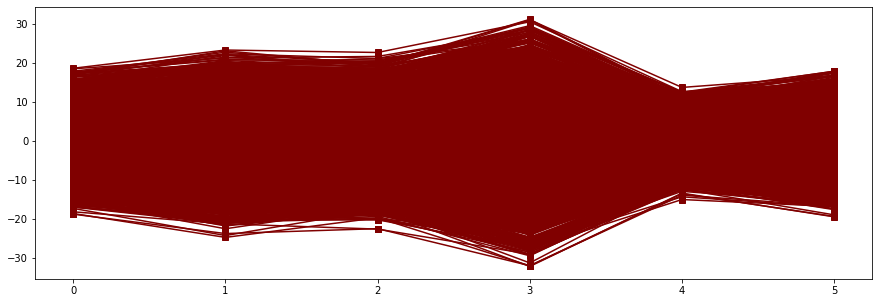

In [ ]:
b = np.array(objects_data_4d_split[13, :, 2, :]) 

plt.rcParams["figure.figsize"] = (15,5)
plt.plot(b, label='c3 - theta', color='maroon', marker='s')

In [ ]:
b = np.array(objects_data_4d_split[0, :, 2, :]) 

plt.rcParams["figure.figsize"] = (15,5)
plt.plot(b, label='c3 - theta', color='maroon', marker='s')

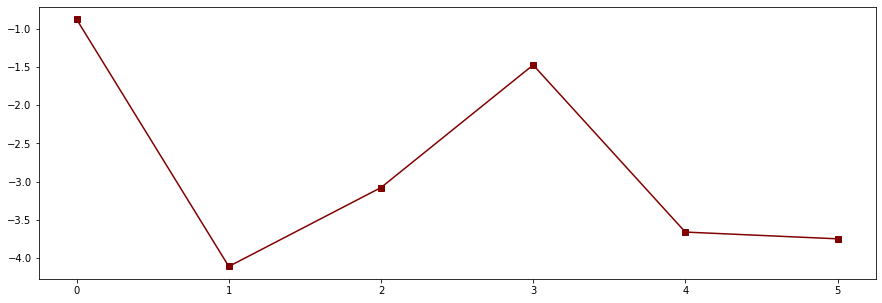

In [ ]:
b = np.array(objects_data_4d_split[1, :, 0, 0]) 
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(b, label='c3 - theta', color='maroon', marker='s')

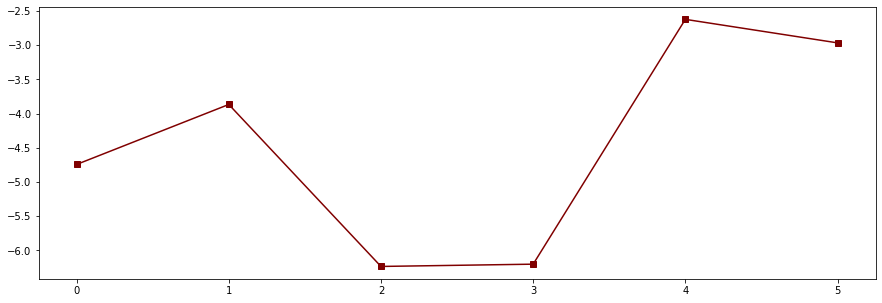

In [ ]:
b = np.array(objects_data_4d_split[2, :, 0, 0]) # joy

plt.rcParams["figure.figsize"] = (15,5)
plt.plot(b, label='c3 - theta', color='maroon', marker='s')

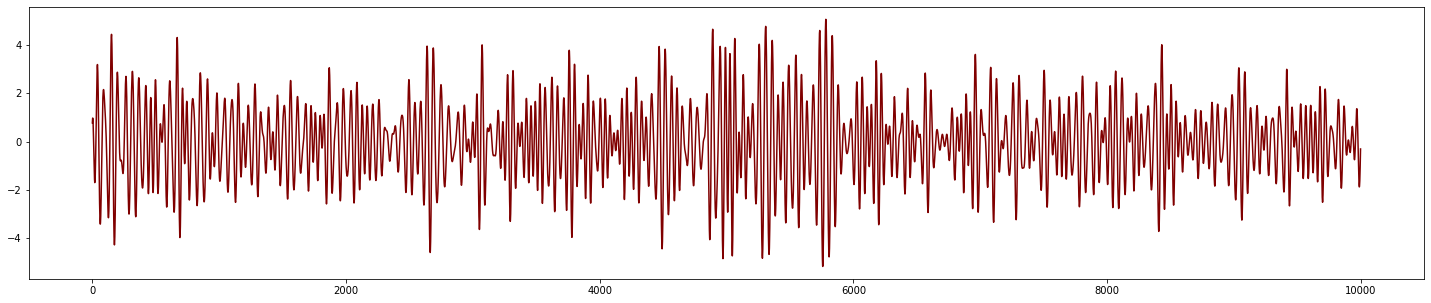

In [ ]:
b = np.array(objects_data_4d_split[10, 0, 0, :])

plt.rcParams["figure.figsize"] = (25,5)
plt.plot(b, label='c3 - theta', color='maroon')

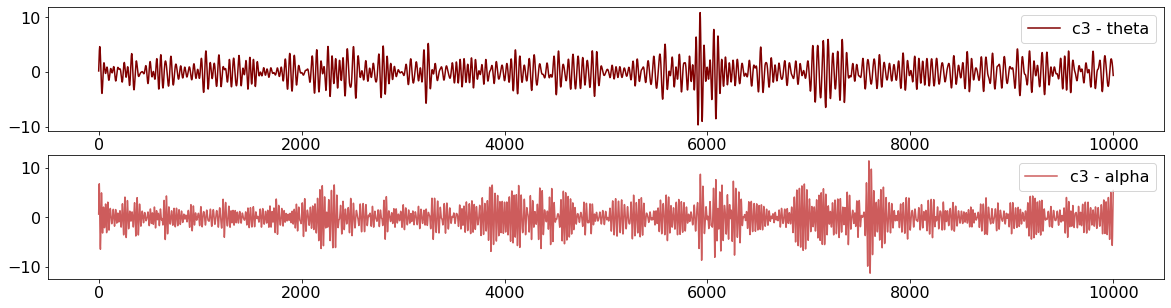

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d_split[0, 0, 0, :], label='c3 - theta', color='maroon')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d_split[0, 0, 1, :], label='c3 - alpha', color='indianred')
plt.legend()

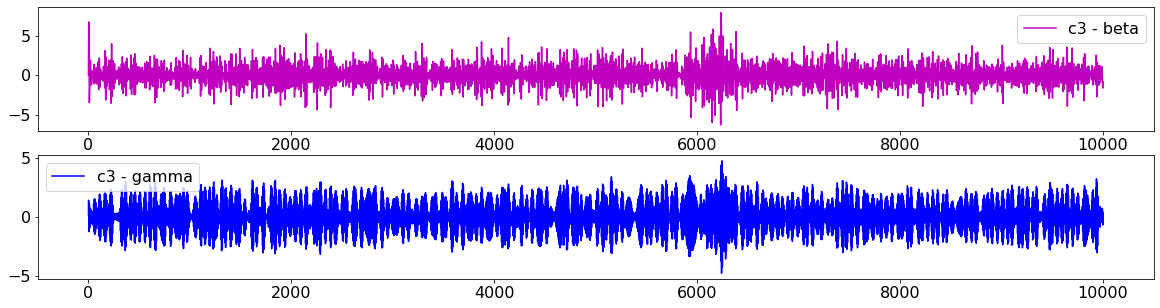

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d_split[0, 0, 2, :], label='c3 - beta', color='m')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d_split[0, 0, 3, :], label='c3 - gamma', color='b')
plt.legend()

In [ ]:
label_list = [ item for item in label_list for repetitions in range(4) ]
label_list

['fear',
 'fear',
 'fear',
 'fear',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'fear',
 'fear',
 'fear',
 'fear']

Shuffle

In [ ]:
objects_data_4d_split, label_list = shuffle(objects_data_4d_split, label_list)
print(label_list)

['fear', 'fear', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'fear', 'fear', 'fear', 'fear', 'joy', 'joy', 'fear', 'fear']


In [ ]:
label_list_0or1 = []
for label in label_list:
  if label == 'joy':
    label_list_0or1.append(0.)
  elif label == 'fear':
    label_list_0or1.append(1.)
    
label_list_0or1 = np.array(label_list_0or1)
print(label_list_0or1)  

[1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1.]


CHANNEL

In [ ]:
objects_data_4d_split = objects_data_4d_split[:,3,:,:] # (objects, channels, bands, values)
objects_data_4d_split.shape

(16, 4, 10000)

TRAIN / TEST 

In [ ]:
num_1 = 0
num_0 = 0
i = 0
index_list = []

while len(index_list)<4:
  if (label_list_0or1[i] == 0) and (num_0!=2):
    index_list.append(i)
    num_0+=1
  elif (label_list_0or1[i] == 1) and (num_1!=2): 
    index_list.append(i)
    num_1+=1
  i+=1
print(i)

4


In [ ]:
x_test = objects_data_4d_split[index_list,:,:]
y_test = label_list_0or1[index_list]
print(y_test)

[1. 1. 0. 0.]


In [ ]:
x_train = np.delete(objects_data_4d_split, index_list, 0)
y_train = np.delete(label_list_0or1, index_list)
print(x_train.shape)

(12, 4, 10000)


Reshape Data

In [ ]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1,1))

In [ ]:
y_train

array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[0.]],

       [[0.]],

       [[1.]],

       [[1.]]], dtype=float32)

In [ ]:
model = Sequential()
model.add(Dense(128, input_shape=(4, values_per_split), activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4, 128)            1280128   
_________________________________________________________________
dense_5 (Dense)              (None, 4, 16)             2064      
_________________________________________________________________
dense_6 (Dense)              (None, 4, 8)              136       
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,282,361
Trainable params: 1,282,361
Non-trainable params: 0
_________________________________________________________________


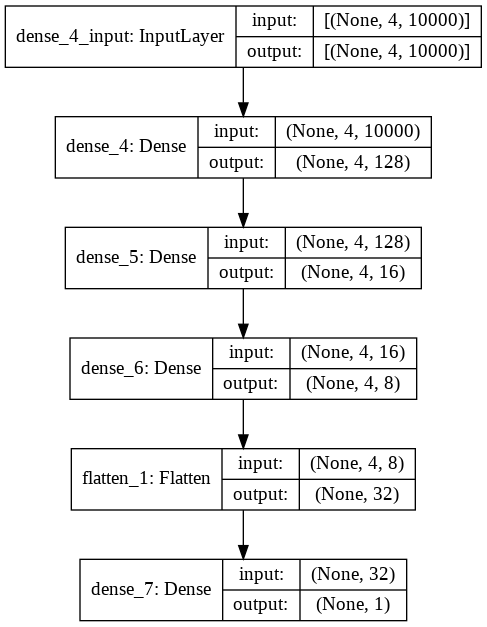

In [ ]:
plot_model(model, to_file=(model_path+'NNmodel_plot.png'), show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(x_train, y_train, epochs=100, batch_size=4, validation_data = (x_test, y_test))

Epoch 1/100
3/3 [==============================] - 1s 125ms/step - loss: 1.0181 - accuracy: 0.1667 - val_loss: 0.8125 - val_accuracy: 0.5000
Epoch 2/100
3/3 [==============================] - 0s 26ms/step - loss: 0.2816 - accuracy: 1.0000 - val_loss: 0.7101 - val_accuracy: 0.7500
Epoch 3/100
3/3 [==============================] - 0s 24ms/step - loss: 0.1622 - accuracy: 1.0000 - val_loss: 0.6385 - val_accuracy: 0.5000
Epoch 4/100
3/3 [==============================] - 0s 26ms/step - loss: 0.1078 - accuracy: 1.0000 - val_loss: 0.5950 - val_accuracy: 0.7500
Epoch 5/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0901 - accuracy: 1.0000 - val_loss: 0.5719 - val_accuracy: 0.7500
Epoch 6/100
3/3 [==============================] - 0s 35ms/step - loss: 0.0761 - accuracy: 1.0000 - val_loss: 0.5524 - val_accuracy: 1.0000
Epoch 7/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0666 - accuracy: 1.0000 - val_loss: 0.5389 - val_accuracy: 1.0000
Epoch 8/100
3/3 [==

In [ ]:
_, accuracy = model.evaluate(x_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1/1 [==============================] - 0s 203ms/step - loss: 0.3702 - accuracy: 1.0000
Accuracy: 100.00


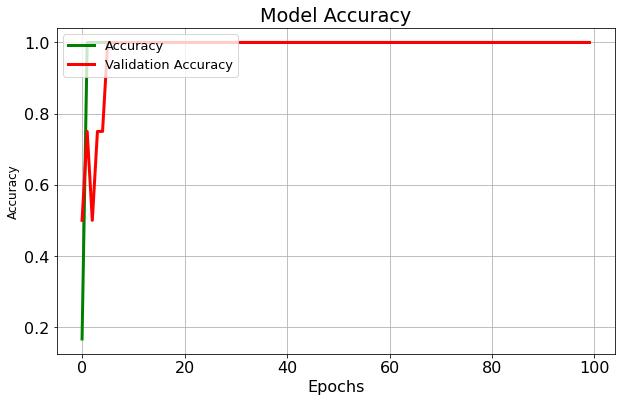

In [ ]:
plt.figure(figsize=(10,6), frameon=True)
plt.rcParams.update({'font.size': 16})

plt.plot(history.history['accuracy'], 'g', linewidth=3)
plt.plot(history.history['val_accuracy'], 'r', linewidth=3)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy', fontsize=12)
plt.legend(['Accuracy', 'Validation Accuracy'], loc = 'upper left', fontsize=13)
plt.grid(True)
plt.show()

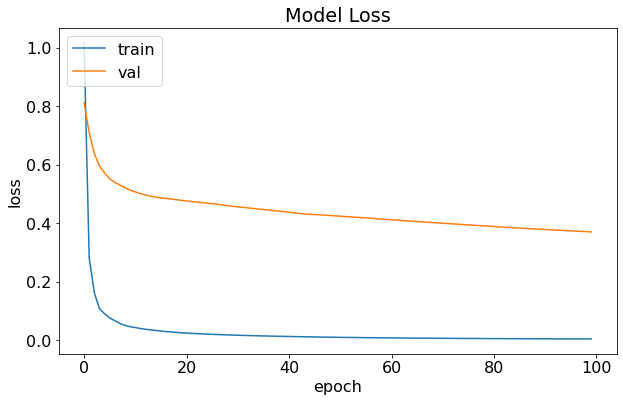

In [ ]:
plt.figure(figsize=(10,6), frameon=True)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<Figure size 576x360 with 0 Axes>

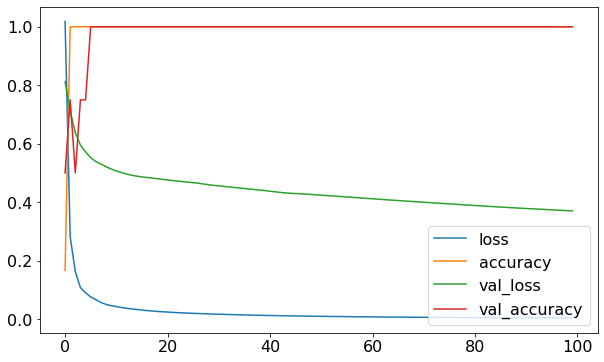

In [ ]:
plt.figure(figsize=(8,5), frameon=True)
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.show()

In [ ]:
model.save(os.path.join(model_path, (model_name + '_MODEL.h5')))
print('Saved trained model at %s ' % model_path)

model_json = model.to_json()
with open((model_path + model_name + '_MODEL.json'), "w") as json_file:
    json_file.write(model_json)

Saved trained model at /content/drive/MyDrive/Brain/EEG_Models/ 


In [ ]:
json_file = open(model_path + model_name + '_MODEL.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(model_path + model_name + '_MODEL.h5')
print("Loaded model from disk")

opt = tf.keras.optimizers.Adam(learning_rate=0.0001) 
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Loaded model from disk


In [ ]:
x_test.shape

(4, 4, 10000)

In [ ]:
data[:,3, :,30000:40000].shape

(1, 4, 10000)

In [ ]:
data = ReadObjectData('eeg_bands_object_1_fear')
data = np.asarray(data).reshape(-1, channel_num, 4, values_per_file)  # (-1, 6, 4, 40000)

prediction = loaded_model.predict(data[:,3, :,10000:20000])
#x_test = x_test.reshape(-1, 4, 10000)
#prediction = loaded_model.predict(x_test[1,:,:])

print('Precise Prediction: ', prediction)
result = prediction.round()
result = int(result)

if result == 0:
  print('joy')
elif result == 1:
  print('fear')

Precise Prediction:  [[0.99328876]]
fear
